# データの前処理

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## import

In [45]:
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import tensorflow.keras.layers as layers
# tensorflowのversion
print("tensorflow version is {}".format(tf.__version__))

tensorflow version is 2.3.0


In [46]:
np.random.seed(0)
tf.random.set_seed(0)

## データセットの生成

In [47]:
from data_generator import DataGenerator
inputfilename = "./input/questionnaire_latest.csv"
dg = DataGenerator(inputfilename)
dg.generate()
# データセットへのアクセス
#dg.df_static_info_binary   # 静的情報（バイナリベクトル）
#dg.df_static_info_weight   # 静的情報（重み付きベクトル）
#dg.df_dynamic_info         # 動的情報
#dg.df_human_info           # 性格情報

In [103]:
def split_label(df):
    culm = len(df.iloc[0])-1
    return df.iloc[:,:culm], df.iloc[:,culm]

def dataset(dg, test_size=0.15):
    # trainデータとtestデータに分ける
    #train, test = train_test_split(dg, test_size=test_size)
    calm = len(dg.iloc[:])
    train = dg.iloc[:calm - 5].reset_index(drop=True)
    test  = dg.iloc[calm - 5:].reset_index(drop=True)
    
    # 特徴量と正解ラベルを分ける
    x_train, y_train = split_label(train)
    x_test, y_test = split_label(test)
    
    print(x_train.shape)
    # 標準化する
    x_train = scale(x_train, axis=0)
    x_test = scale(x_test, axis=0)
    
    # np.arrayに変換する
    y_train = np.array(y_train.tolist())
    y_test  = np.array(y_test.tolist())
    
    return x_train, y_train, x_test, y_test

In [104]:
# 静的情報におけるバイナリベクトルのデータセット(今回は使わない)
x_train_b, y_train_b, x_test_b, y_test_b = dataset(dg.df_static_info_binary)

(32, 8)


In [105]:
# 静的情報における重み付きベクトルのデータセット(今回はこれがメイン)
x_train_w, y_train_w, x_test_w, y_test_w = dataset(dg.df_static_info_weight)

(32, 8)


In [109]:
# 動的情報に関するデータセット(短期トレンドモデルで用いる) 
x_train_d, y_train_d, x_test_d, y_test_d = dataset(dg.df_dynamic_info)

(32, 3)


# 遊びのレコメンドモデルの実装

## リッジ回帰

In [122]:
# 静的モデル
ridge1 = Ridge().fit(x_train_w, y_train_w)
x_train_pred = ridge1.predict(x_train_w)
x_test_pred = ridge1.predict(x_test_w)

In [125]:
# 動的モデル
x_train_in = np.hstack((x_train_pred,x_train_d))
x_test_in = np.hstack((x_test_pred,x_test_d))
ridge2 = Ridge().fit(x_train_in, y_train_d)

In [127]:
ridge2.predict(x_test_in)

array([[ 0.04581845, -0.03716064,  0.0083508 , -0.01278074,  0.60133874,
         0.20793709,  0.18649631],
       [ 0.06772429,  0.10950532,  0.04679773,  0.19147301,  0.26362887,
         0.21793771,  0.10293307],
       [-0.02557032,  0.21510031, -0.04029065,  0.22373448,  0.00087537,
         0.46627505,  0.15987576],
       [-0.03334623,  0.29478117,  0.12419913,  0.17581092,  0.13048832,
         0.33628078, -0.02821411],
       [ 0.10162381, -0.11347616,  0.01719299,  0.04676233,  0.56616869,
         0.02156937,  0.36015897]])

In [128]:
y_test_d

array([[0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0]])

In [129]:
# 動的モデル
x_train_in = x_train_pred
x_test_in = x_test_pred
ridge2 = Ridge().fit(x_train_in, y_train_d)

In [130]:
ridge2.predict(x_test_in)

array([[ 0.11925246,  0.07179396, -0.01358847,  0.01757556,  0.68156016,
         0.06944006,  0.05396626],
       [ 0.02778961,  0.0370523 ,  0.07268236,  0.16799154,  0.23107451,
         0.31235321,  0.15105646],
       [-0.00357646,  0.18467095, -0.0132405 ,  0.18324037, -0.05153252,
         0.55620508,  0.14423307],
       [-0.10361902,  0.25669776,  0.05572317,  0.17210072, -0.0781993 ,
         0.39681704,  0.30047962],
       [ 0.1164034 , -0.08146497,  0.05467344,  0.08409181,  0.77959715,
        -0.0848154 ,  0.13151458]])

In [131]:
y_test_d

array([[0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0]])

# 遊びに行くメンバーのレコメンドモデルの実装

## T-SNE

In [107]:
X = dg.df_human_info
X = scale(X, axis=0)
tsne = TSNE(n_components=2, perplexity=5,).fit_transform(X[:,[0,1,3,5]])
print(tsne.shape)

(44, 2)


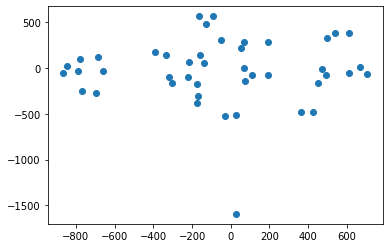

In [108]:
plt.scatter(tsne[:,0],tsne[:,1])

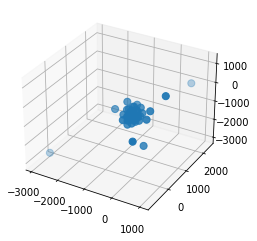

In [9]:
# 3D可視化
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=tsne[:,0], ys=tsne[:,1], zs=tsne[:,2], zdir='z', s=50, c=None, depthshade=True)

## 主成分分析

In [10]:
X = dg.df_human_info
X = scale(X, axis=0)
pca = PCA(n_components=3)
pca.fit(X)
x_pca = pca.transform(X)
sum(pca.explained_variance_ratio_)

0.7081007695172404

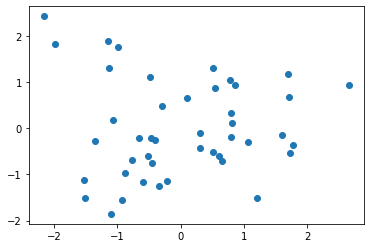

In [11]:
plt.scatter(x_pca[:,1],x_pca[:,2])

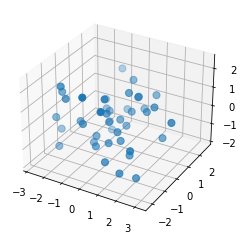

In [12]:
# 3D可視化
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=x_pca[:,0], ys=x_pca[:,1], zs=x_pca[:,2], zdir='z', s=50, c=None, depthshade=True)

## k-means

In [27]:
X = dg.df_human_info
#X = scale(X, axis=0)

In [180]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300,
         tol=0.0001,precompute_distances='auto', verbose=0,
         random_state=None, copy_x=True, n_jobs=1)

kmeans.fit(X)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:934: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  "effect", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


KMeans(n_clusters=2, n_jobs=1, precompute_distances='auto')

In [181]:
print(kmeans.predict(X))
results = pd.DataFrame({'classter': kmeans.predict(X)})

[0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 0 0
 1 0 1 0 0 1 0]


In [183]:
df_classtor_stat = dg.df_human_info
df_classtor_stat['label'] = results

In [184]:
df_classtor_stat.groupby('label').agg([np.mean, np.median, np.var, np.std]).T

label                                   0         1
通常，自分から話を始めることはない        mean    1.578947  3.200000
                         median  2.000000  3.000000
                         var     0.923977  1.583333
                         std     0.961237  1.258306
どちらかというと控えめで，静かな性格である    mean    2.263158  3.560000
                         median  2.000000  4.000000
                         var     2.093567  1.506667
                         std     1.446916  1.227464
深く考えるより，すぐに行動したい         mean    2.947368  3.320000
                         median  3.000000  3.000000
                         var     1.719298  1.726667
                         std     1.311220  1.314027
リーダーとして皆を引っ張っていきたい       mean    2.526316  1.320000
                         median  2.000000  1.000000
                         var     2.040936  1.976667
                         std     1.428613  1.405940
近くでイベントがあれば参加するほうだ       mean    2.894737  1.960000
                         median  3.000000  2.000000
                         var     0.988304  1.123333
                         std     0.994135  1.059874
どちらかというと，開放的で，陽気なタイプだと思う mean    3.000000  1.160000
                         median  3.000000  1.000000
                         var     0.666667  1.140000
                         std     0.816497  1.067708

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

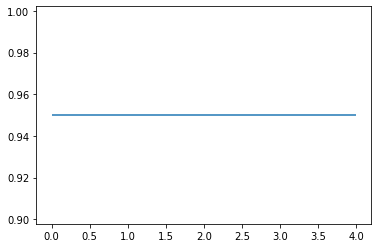

In [109]:
plt.figure()
plt.hlines(0.95,0,4)  # Draw a horizontal line
plt.eventplot(X.iloc[:,5], orientation='horizontal', colors='b')
plt.axis('off')
plt.show()

In [44]:
X.groupby('どちらかというと，開放的で，陽気なタイプだと思う').count()

,通常，自分から話を始めることはない,どちらかというと控えめで，静かな性格である,深く考えるより，すぐに行動したい,リーダーとして皆を引っ張っていきたい,近くでイベントがあれば参加するほうだ
どちらかというと，開放的で，陽気なタイプだと思う,,,,,
0,9,9,9,9,9
1,6,6,6,6,6
2,13,13,13,13,13
3,10,10,10,10,10
4,6,6,6,6,6


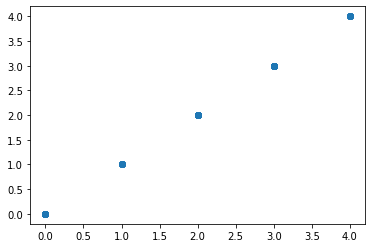

In [26]:
plt.scatter(X.iloc[:,5],X.iloc[:,5])

# 不採択になったモデル

## MLP

### モデルの実装

In [25]:
def create_model():
    inputs = layers.Input((8,))
    x = layers.Dense(2, activation="sigmoid")(inputs)
    x = layers.Dense(8, activation="sigmoid")(x)
    return tf.keras.models.Model(inputs=inputs, outputs=x)

def main():    
    model = create_model()
    loss = tf.keras.losses.MeanSquaredError()
    acc = tf.keras.losses.MeanSquaredError()
    optim = tf.keras.optimizers.Adam()

    # train
    model.compile(optimizer=optim, loss=loss, metrics=[acc])
    model.fit(x_train_w, y_train_w, validation_data=(x_test_w, y_test_w), epochs=20, batch_size=4)

    # eval
    val_loss, val_acc = model.evaluate(x_test_w, y_test_w, batch_size=4)
    
    return model 

if __name__ == "__main__":
    model = main()

Epoch 1/20
10/10 [==============================] - 0s 15ms/step - loss: 0.1748 - mean_squared_error: 0.1740 - val_loss: 0.1617 - val_mean_squared_error: 0.1637
Epoch 2/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1730 - mean_squared_error: 0.1730 - val_loss: 0.1600 - val_mean_squared_error: 0.1620
Epoch 3/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1713 - mean_squared_error: 0.1722 - val_loss: 0.1583 - val_mean_squared_error: 0.1603
Epoch 4/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1696 - mean_squared_error: 0.1692 - val_loss: 0.1566 - val_mean_squared_error: 0.1585
Epoch 5/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1679 - mean_squared_error: 0.1677 - val_loss: 0.1550 - val_mean_squared_error: 0.1569
Epoch 6/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1663 - mean_squared_error: 0.1664 - val_loss: 0.1535 - val_mean_squared_error: 0.1553
Epoch 7/20
10/10 [=====================

### 結果の確認

In [26]:
raw = 0

In [27]:
print(model.predict(x_test_w[raw:raw+1,:]))

[[0.33778268 0.506331   0.48925483 0.4798966  0.28250325 0.47609758
  0.4129015  0.35314476]]


In [28]:
print(y_test_w[raw,:])

[0.  0.  0.4 0.  0.  0.7 1.  0. ]


## ランダムフォレスト

In [7]:
clf = RandomForestClassifier(max_depth=5, random_state=0)

In [8]:
# original
clf.fit(x_train,y_train)

# pca
#clf.fit(x_train_pca,y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [9]:
print(clf.feature_importances_)

[0.03545779 0.03583479 0.07081688 0.07663516 0.07443875 0.07018595
 0.1078693  0.0668443  0.0823463  0.05600769 0.08187283 0.07853895
 0.08160876 0.08154253]


In [10]:
# original
clf.score(x_test,y_test)

# pca
#clf.score(x_test_pca,y_test)

0.13333333333333333